In [1]:
import os
import sys
import math

import ROOT

import CMS_lumi as CMS_lumi
import tdrstyle as tdrstyle
from datasets import dsetdb

tdrstyle.setTDRStyle()
ROOT.gStyle.SetPalette(1)

Welcome to JupyROOT 6.10/08


In [2]:
# set up dataset objects

class Dataset(object):
    def __init__(self, name, filepath):
        self.name = name
        self.tfilename = filepath
        self.tfile = ROOT.TFile.Open(self.tfilename)
        try:
            # get xsec and sumw/nevents
            tsummary = self.tfile.Get('Summary')
            tsummary.GetEntry(0)
            self.xsec = tsummary.tCrossSec
            self.sumw = 0.
            self.nevt = 0
            for entry in range(tsummary.GetEntries()):
                tsummary.GetEntry(entry)
                self.sumw += tsummary.tSumWts
                self.nevt += tsummary.tNumEvts
        except:
            print 'ERROR opening file ' + self.tfilename
            self.tfile = None
            self.xsec = -1.
            self.sumw = -1.
            self.nevt = -1


        # sig, bkg, or data
        self.kind = dsetdb[name]['kind']
        # for the stack
        self.group = dsetdb[name]['group']
        # for the legend
        self.label = dsetdb[name]['label']
        # if data
        self.lumi = dsetdb[name]['lumi'] if self.group=='data' else -1.

    def set_xsec(self, xsec):
        self.xsec = xsec
    def set_sumwts(self, sumw):
        self.sumw = sumw

    def get_label(self):
        return self.label
    def get_lumi(self):
        return self.lumi
    def get_tfile(self):
        return self.tfile
    def get_hist(self, histname):
        return self.tfile.Get(histname)
    
    def get_scale(self, lumi):
        return (lumi * self.xsec) / self.sumw


    def print_info(self):
        print
        print 'self.name  = ' + self.name
        print 'self.tfile = ' + self.tfilename
        print 'self.kind  = ' + self.kind
        print 'self.group = ' + self.group
        print 'self.label = ' + self.label
        print 'self.lumi  = ' + str(self.lumi)
        print 'self.xsec  = ' + str(self.xsec)
        print 'self.sumw  = ' + str(self.sumw)
        print 'self.nevt  = ' + str(self.nevt)
        print

In [3]:
# list of background monte carlo
# (this is also the order they will be stacked in)
bkg_list = [
    'DYJetsToLL',
    'TTJets',
    'ZZTo2L2Nu',
    'ZZTo2L2Q',
    'ZZTo4L',
    'WZTo2L2Q',
    'WZTo3LNu',
    #'WWTo2L2Nu',
    'TTZToLLNuNu',
    #'TTWJetsToLNu'
]


# lists to hold the Dataset objects
d_mc = []

# set up Dataset objects
for d in bkg_list:
    d_mc.append(
        Dataset(d, 'data/ana_2Mu_{0}.root'.format(d))
    )
# only have one data
d_data = Dataset('SingleMuon_Run2016', 'data/ana_2Mu_SingleMuon_Run2016.root')


# check a few Dataset objects
d_mc[0].print_info()
d_mc[-1].print_info()
d_data.print_info()


self.name  = DYJetsToLL
self.tfile = data/ana_2Mu_DYJetsToLL.root
self.kind  = bkg
self.group = DY
self.label = DY+Jets
self.lumi  = -1.0
self.xsec  = 5765.0
self.sumw  = 4.54866395136e+11
self.nevt  = 28968252


self.name  = TTZToLLNuNu
self.tfile = data/ana_2Mu_TTZToLLNuNu.root
self.kind  = bkg
self.group = TTV
self.label = TTZ#rightarrow2l2#nu
self.lumi  = -1.0
self.xsec  = 0.252900004387
self.sumw  = 1992438.0
self.nevt  = 1992438


self.name  = SingleMuon_Run2016
self.tfile = data/ana_2Mu_SingleMuon_Run2016.root
self.kind  = data
self.group = data
self.label = SingleMuon 2016 B-H
self.lumi  = 35920.0
self.xsec  = 1.0
self.sumw  = 785964720.0
self.nevt  = 785964720



In [4]:
# parameters of final plot
lumi = d_data.get_lumi() # pb
print 'Scaling to '+str(lumi)+' picobarns.'
xaxis = 'M_{#mu#mu} [GeV]'
yaxis = 'Events / 0.5 GeV'
ymin = 1.
isprelim = True
ratiomin = 0.9
ratiomax = 1.1
rangex = [70,135]

Scaling to 35920.0 picobarns.


In [5]:
# read in plain histograms from root files
h_mc = []
for d in d_mc:
    h_mc.append(d.get_hist('categories/hDiMuInvMass_cat00'))
# only have one data
h_data = d_data.get_hist('categories/hDiMuInvMass_cat00')

canvname = 'hDiMuInvMass_cat00'

# format and scale them
h_data.SetTitle('Observed')
h_data.SetMarkerSize(0.6)
h_data.SetMarkerStyle(20)
h_data.SetMarkerColor(ROOT.kBlack)
h_data.SetLineColor(ROOT.kBlack)

for i, h in enumerate(h_mc):
    #if i < 2: continue
    h.SetTitle(d_mc[i].get_label())
    h.SetFillColor(26+3*i)
    h.SetLineColor(26+3*i)
    h.Scale(d_mc[i].get_scale(lumi))

stack = ROOT.THStack('stack','stack')

for h in reversed(h_mc):
    stack.Add(h)

In [6]:
# create canvas
canvas = ROOT.TCanvas(canvname,canvname,50,50,800,600)
plotpad = ROOT.TPad('plotpad', 'plotpad', 0.0, 0.20, 1.0, 1.0)
plotpad.SetBottomMargin(0.04)
plotpad.SetRightMargin(0.03)
plotpad.Draw()
ratiopad = ROOT.TPad('pullpad', 'pullpad', 0.0, 0.0, 1.0, 0.20)
ratiopad.SetTopMargin(0.06)
ratiopad.SetRightMargin(0.03)
ratiopad.SetBottomMargin(0.5)
ratiopad.SetLeftMargin(0.16)
ratiopad.SetTickx(1)
ratiopad.SetTicky(1)
ratiopad.Draw()
plotpad.cd()

# now draw them
stack.Draw('hist')
stack.GetXaxis().SetTitle(xaxis)
stack.GetYaxis().SetTitle(yaxis)
stack.GetYaxis().SetLabelSize(0.05)
#stack.SetMinimum(ymin)
stack.SetMaximum(stack.GetHistogram().GetMaximum()*1.2)

if rangex: stack.GetXaxis().SetRangeUser(*rangex)

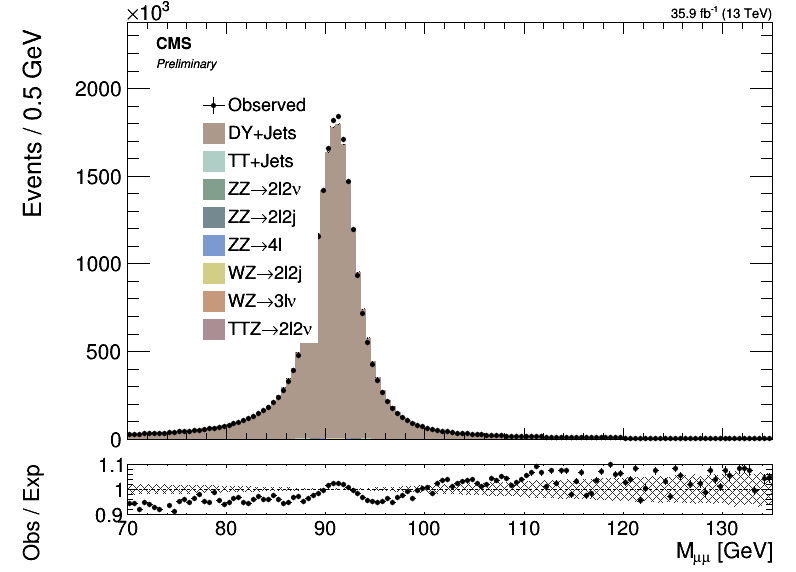

In [7]:
# staterr for stack
stack.GetHistogram().GetXaxis().SetLabelOffset(999)
staterr = stack.GetStack().Last().Clone('{0}_staterr'.format(stack.GetName))
staterr.SetFillColor(ROOT.kGray+3)
staterr.SetLineColor(ROOT.kGray+3)
staterr.SetLineWidth(0)
staterr.SetMarkerSize(0)
staterr.SetFillStyle(3013)
staterr.Draw('e2 same')
h_data.Draw('ex0 same')

# make the legend
entries = [[h_data,h_data.GetTitle(),'lep']]
for h in reversed(stack.GetHists()):
    entries += [[h,h.GetTitle(),'f']]

legend = ROOT.TLegend(0.25,  0.25,  0.4,  0.8,'','NDC')
legend.SetTextFont(42)
legend.SetBorderSize(0)
legend.SetFillColor(0)
for entry in entries:
    legend.AddEntry(*entry)
legend.Draw()

# cms styling
period_int = 4
lumipos = 11
if plotpad != ROOT.TVirtualPad.Pad(): plotpad.cd()
CMS_lumi.writeExtraText = isprelim
CMS_lumi.extraText = 'Preliminary'
CMS_lumi.lumi_13TeV = '%0.1f fb^{-1}' % (float(lumi)/1000.)
if lumi < 1000:
    CMS_lumi.lumi_13TeV = '%0.1f pb^{-1}' % (float(lumi))
CMS_lumi.CMS_lumi(plotpad,period_int,lumipos)


# the ratio portion for stack
denom = stack.GetStack().Last().Clone('denom')
ratiostaterr = denom.Clone('{0}_ratiostaterr'.format(denom.GetName))
ratiostaterr.SetStats(0)
ratiostaterr.SetTitle('')
ratiostaterr.GetYaxis().SetTitle('Obs / Exp')
ratiostaterr.SetMaximum(ratiomax)
ratiostaterr.SetMinimum(ratiomin)
ratiostaterr.SetMarkerSize(0)
ratiostaterr.SetFillColor(ROOT.kGray+3)
ratiostaterr.SetFillStyle(3013)
ratiostaterr.GetXaxis().SetLabelSize(0.19)
ratiostaterr.GetXaxis().SetTitleSize(0.21)
ratiostaterr.GetXaxis().SetTitleOffset(1.0)
ratiostaterr.GetXaxis().SetLabelOffset(0.03)
ratiostaterr.GetYaxis().SetLabelSize(0.19)
ratiostaterr.GetYaxis().SetLabelOffset(0.006)
ratiostaterr.GetYaxis().SetTitleSize(0.21)
ratiostaterr.GetYaxis().SetTitleOffset(0.35)
ratiostaterr.GetYaxis().SetNdivisions(503)

# bin by bin errors
for i in range(denom.GetNbinsX()+2):
    ratiostaterr.SetBinContent(i, 1.0)
    if denom.GetBinContent(i)>1e-6:  # not empty
        binerror = denom.GetBinError(i) / denom.GetBinContent(i)
        ratiostaterr.SetBinError(i, binerror)
    else:
        ratiostaterr.SetBinError(i, 999.)
ratiostaterr.SetXTitle(xaxis)

unityargs = [rangex[0],1,rangex[1],1] if rangex else [denom.GetXaxis().GetXmin(),1,denom.GetXaxis().GetXmax(),1]
ratiounity = ROOT.TLine(*unityargs)
ratiounity.SetLineStyle(2)

# ratio for data
dataratio = h_data.Clone('ratio_{0}'.format(h_data.GetName()))
for b in range(h_data.GetNbinsX()):
    nVal = h_data.GetBinContent(b+1)
    nErr = h_data.GetBinError(b+1)
    dVal = denom.GetBinContent(b+1)
    if dVal>1e-6:
        val = nVal/dVal
        err = nErr/dVal
    else:
        val = 0
        err = 0
    dataratio.SetBinContent(b+1,val)
    dataratio.SetBinError(b+1,err)

# draw ratio
if ratiopad != ROOT.TVirtualPad.Pad(): ratiopad.cd()
ratiostaterr.Draw('e2')
if rangex: ratiostaterr.GetXaxis().SetRangeUser(*rangex)
ratiounity.Draw('same')
dataratio.Draw('0P same')

canvas.Draw()

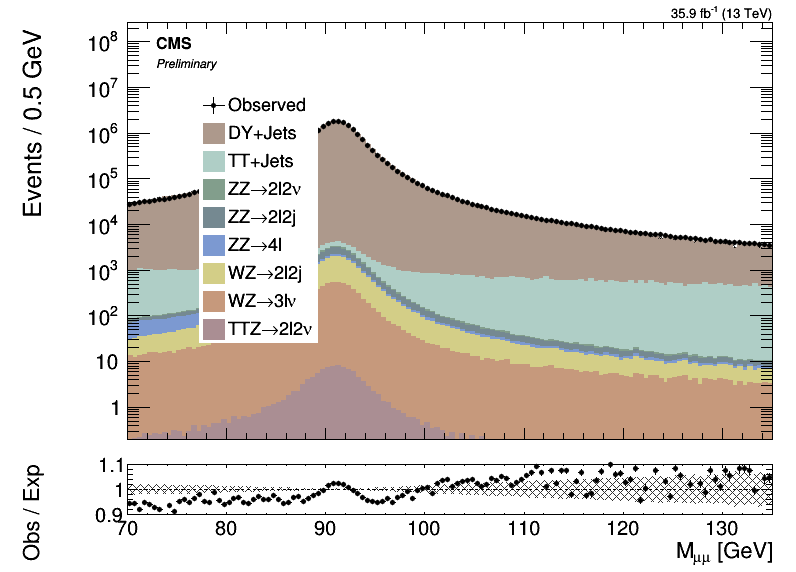

In [8]:
stack.SetMaximum(100000000.)
stack.SetMinimum(1.)
plotpad.SetLogy()
canvas.Draw()